C:\ProgramData\Anaconda3\envs\ipykernel_py2\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")



LSI Model Started
[(0, u'-0.663*"ball" + -0.569*"team" + -0.200*"person" + -0.152*"point" + -0.131*"obstacle" + -0.127*"time" + -0.116*"player" + -0.105*"pass" + -0.085*"goal" + -0.083*"kind"'), (1, u'-0.692*"team" + 0.530*"ball" + 0.202*"pass" + 0.126*"movement" + 0.122*"guard" + 0.107*"throw" + 0.105*"shoot" + -0.100*"obstacle" + -0.096*"workout" + -0.093*"take"'), (2, u'-0.533*"race" + -0.465*"person" + -0.293*"field" + -0.249*"point" + -0.206*"bag" + -0.171*"winner" + -0.171*"return" + -0.169*"end" + 0.157*"ball" + -0.155*"line"'), (3, u'-0.390*"player" + 0.386*"person" + 0.290*"obstacle" + -0.269*"endzone" + -0.231*"game" + -0.185*"point" + -0.183*"field" + -0.170*"ground" + -0.156*"line" + 0.155*"time"'), (4, u'-0.424*"point" + -0.338*"pass" + 0.300*"endzone" + 0.256*"player" + -0.197*"movement" + -0.195*"guard" + 0.180*"ground" + 0.179*"person" + -0.171*"throw" + -0.143*"shoot"')]
LSI Model Ended

HDP Model Started
[(0, u'0.022*place + 0.016*goal + 0.015*middle + 0.013*time + 0

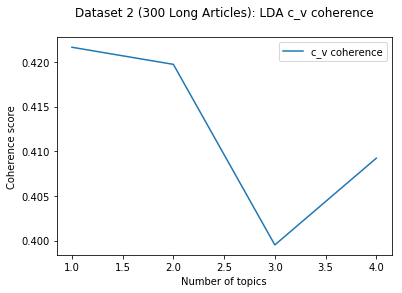

LDA Model Detected. Generating graph...


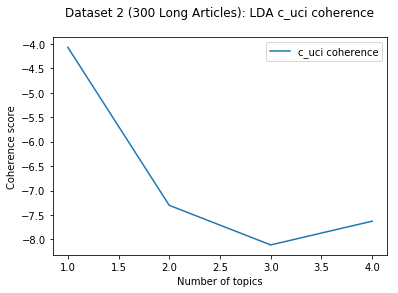

LDA Model Detected. Generating graph...


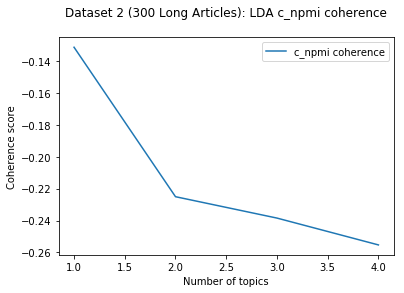

LDA Model Detected. Generating graph...


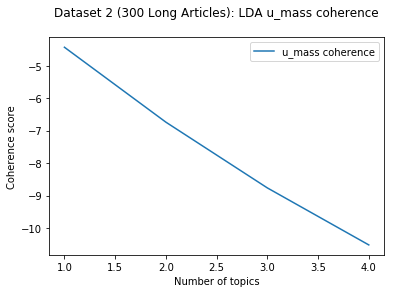

HDP Model Detected. Generating graph...


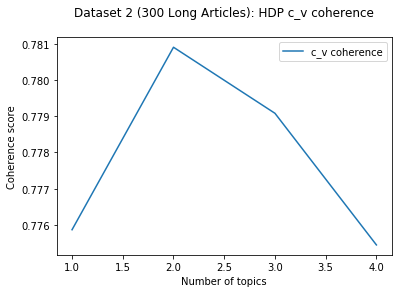

HDP Model Detected. Generating graph...


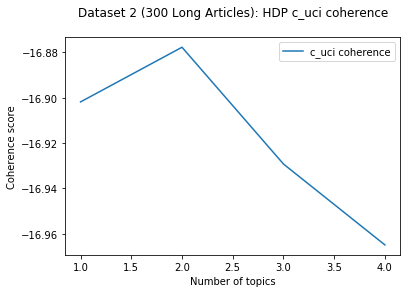

HDP Model Detected. Generating graph...


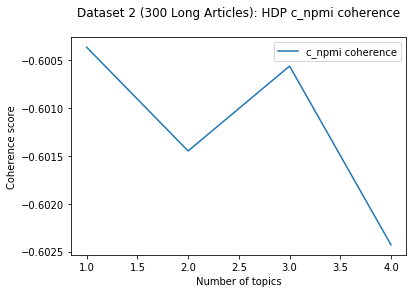

HDP Model Detected. Generating graph...


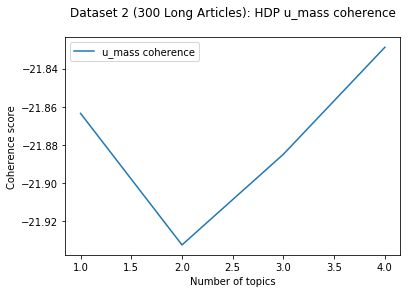

LSI Model Detected. Generating graph...


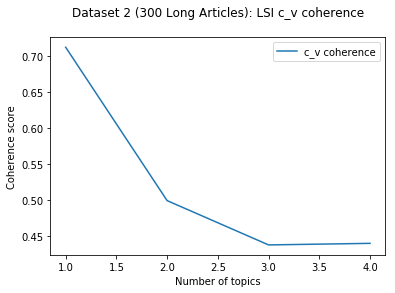

LSI Model Detected. Generating graph...


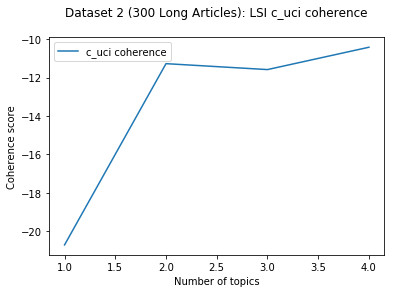

LSI Model Detected. Generating graph...


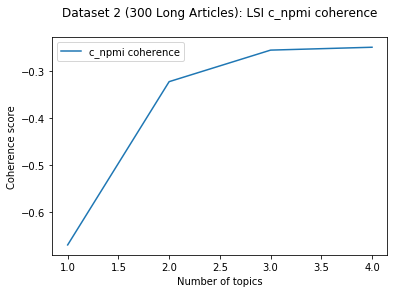

LSI Model Detected. Generating graph...


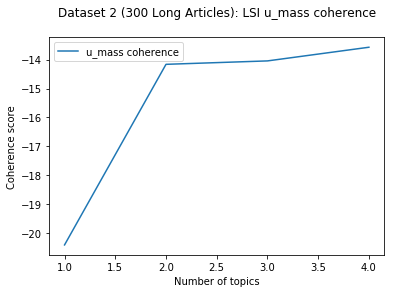

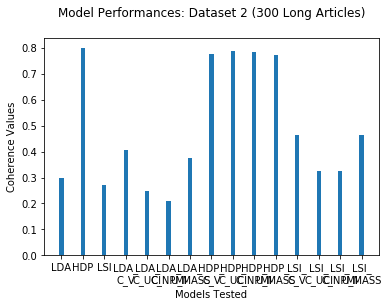

In [1]:
import os
import re
import operator
import matplotlib.pyplot as plt
import warnings
import gensim
import numpy as np
warnings.filterwarnings('ignore')

%matplotlib inline

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint

from gensim.utils import lemmatize
from nltk.corpus import stopwords

test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'sports.cor'

def build_texts(fname):
    with open(fname) as f:
        for line in f:
            yield gensim.utils.simple_preprocess(line, deacc=True, min_len=3)

train_texts = list(build_texts(lee_train_file))

bigram = gensim.models.Phrases(train_texts)

stops = set(stopwords.words('english'))

def process_texts(texts):
    texts = [[word for word in line if word not in stops] for line in texts]
    texts = [bigram[line] for line in texts]
    texts = [[word.split('/')[0] for word in lemmatize(' '.join(line), allowed_tags=re.compile('(NN)'), min_length=3)] for line in texts]
    return texts

train_texts = process_texts(train_texts)

dictionary = Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]

print '\nLSI Model Started'
lsimodel = LsiModel(corpus=corpus, num_topics=5, id2word=dictionary)
print lsimodel.show_topics(num_topics=5)
lsitopics = lsimodel.show_topics(formatted=False)

print 'LSI Model Ended\n\nHDP Model Started'
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
print hdpmodel.show_topics()
hdptopics = hdpmodel.show_topics(formatted=False)

print 'HDP Model Ended\n\nLDA Model Started'
ldamodel = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary)
print ldamodel.show_topics()
ldatopics = ldamodel.show_topics(formatted=False)
print 'LDA Model Ended\n'

print 'Creating graphs...\n'

def evaluate_graph_general(dictionary, corpus, texts, limit, measure, model):
    coh_measure = []
    lm_list = []
    if model == 'LdaModel':
        print 'LDA Model Detected. Generating graph...'
    elif model == 'HdpModel':
        print 'HDP Model Detected. Generating graph...'
    elif model == 'LsiModel':
        print 'LSI Model Detected. Generating graph...'
    else:
        print 'Invalid Model!'
    
    for num_topics in range(1, limit):
        if model == 'LdaModel':
            lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        elif model == 'HdpModel':
            lm = HdpModel(corpus=corpus, id2word=dictionary)
        elif model == 'LsiModel':
            lm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        else:
            print 'Invalid Model!'
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence=measure)
        coh_measure.append(cm.get_coherence())

    # Show graph
    x = range(1, limit)
    
    if model == 'LdaModel':
        title = 'Dataset 2 (300 Long Articles): LDA'
    elif model == 'HdpModel':
        title = 'Dataset 2 (300 Long Articles): HDP'
    elif model == 'LsiModel':
        title = 'Dataset 2 (300 Long Articles): LSI'
    else:
        title = 'ERROR GRAPH'
    
    if measure == 'c_v':
        coh_label = 'c_v coherence'
    elif measure == 'c_uci':
        coh_label = 'c_uci coherence'
    elif measure == 'c_npmi':
        coh_label = 'c_npmi coherence'
    elif measure == 'u_mass':
        coh_label = 'u_mass coherence'
    else:
        coh_label = 'ERROR LABEL'
    
    plt.plot(x, coh_measure, label=coh_label)
    plt.title(title + ' ' + coh_label + '\n')
    plt.xlabel("Number of topics")
    plt.ylabel("Coherence score")
    plt.legend(loc='best')
    plt.show()

    return lm_list, coh_measure

# ----------------------------------LDA----------------------------------
# ----------------------------------c_v----------------------------------
ldalist_c_v, lda_c_v = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=5,
                                             measure='c_v',
                                             model='LdaModel')
ldatopics_c_v = ldalist_c_v[2].show_topics(formatted=False)
# ----------------------------------c_uci----------------------------------
ldalist_c_uci, lda_c_uci = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=5,
                                             measure='c_uci',
                                             model='LdaModel')
ldatopics_c_uci = ldalist_c_uci[2].show_topics(formatted=False)
# ----------------------------------c_npmi----------------------------------
ldalist_c_npmi, lda_c_npmi = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=5,
                                             measure='c_npmi',
                                             model='LdaModel')
ldatopics_c_npmi = ldalist_c_npmi[2].show_topics(formatted=False)
# ----------------------------------u_mass----------------------------------
ldalist_u_mass, lda_u_mass = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=5,
                                             measure='u_mass',
                                             model='LdaModel')
ldatopics_u_mass = ldalist_u_mass[2].show_topics(formatted=False)
# ----------------------------------LDA----------------------------------

# ----------------------------------HDP----------------------------------
# ----------------------------------c_v----------------------------------
hdplist_c_v, hdp_c_v = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=5,
                                             measure='c_v',
                                             model='HdpModel')
hdptopics_c_v = hdplist_c_v[2].show_topics(formatted=False)
# ----------------------------------c_uci----------------------------------
hdplist_c_uci, hdp_c_uci = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=5,
                                             measure='c_uci',
                                             model='HdpModel')
hdptopics_c_uci = hdplist_c_uci[2].show_topics(formatted=False)
# ----------------------------------c_npmi----------------------------------
hdplist_c_npmi, hdp_c_npmi = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=5,
                                             measure='c_npmi',
                                             model='HdpModel')
hdptopics_c_npmi = hdplist_c_npmi[2].show_topics(formatted=False)
# ----------------------------------u_mass----------------------------------
hdplist_u_mass, hdp_u_mass = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=5,
                                             measure='u_mass',
                                             model='HdpModel')
hdptopics_u_mass = hdplist_u_mass[2].show_topics(formatted=False)
# ----------------------------------HDP----------------------------------

# ----------------------------------LSI----------------------------------
# ----------------------------------c_v----------------------------------
lsilist_c_v, lsi_c_v = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=5,
                                             measure='c_v',
                                             model='LsiModel')
lsitopics_c_v = lsilist_c_v[2].show_topics(formatted=False)
# ----------------------------------c_uci----------------------------------
lsilist_c_uci, lsi_c_uci = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=5,
                                             measure='c_uci',
                                             model='LsiModel')
lsitopics_c_uci = lsilist_c_uci[2].show_topics(formatted=False)
# ----------------------------------c_npmi----------------------------------
lsilist_c_npmi, lsi_c_npmi = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=5,
                                             measure='c_npmi',
                                             model='LsiModel')
lsitopics_c_npmi = lsilist_c_npmi[2].show_topics(formatted=False)
# ----------------------------------u_mass----------------------------------
lsilist_u_mass, lsi_u_mass = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=5,
                                             measure='u_mass',
                                             model='LsiModel')
lsitopics_u_mass = lsilist_u_mass[2].show_topics(formatted=False)
# ----------------------------------LSI----------------------------------

ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]

ldatopics_c_v = [[word for word, prob in topic] for topicid, topic in ldatopics_c_v]
ldatopics_c_uci = [[word for word, prob in topic] for topicid, topic in ldatopics_c_uci]
ldatopics_c_npmi = [[word for word, prob in topic] for topicid, topic in ldatopics_c_npmi]
ldatopics_u_mass = [[word for word, prob in topic] for topicid, topic in ldatopics_u_mass]

hdptopics_c_v = [[word for word, prob in topic] for topicid, topic in hdptopics_c_v]
hdptopics_c_uci = [[word for word, prob in topic] for topicid, topic in hdptopics_c_uci]
hdptopics_c_npmi = [[word for word, prob in topic] for topicid, topic in hdptopics_c_npmi]
hdptopics_u_mass = [[word for word, prob in topic] for topicid, topic in hdptopics_u_mass]

lsitopics_c_v = [[word for word, prob in topic] for topicid, topic in lsitopics_c_v]
lsitopics_c_uci = [[word for word, prob in topic] for topicid, topic in lsitopics_c_uci]
lsitopics_c_npmi = [[word for word, prob in topic] for topicid, topic in lsitopics_c_npmi]
lsitopics_u_mass = [[word for word, prob in topic] for topicid, topic in lsitopics_u_mass]

lda_coherence = CoherenceModel(topics=ldatopics, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics[:2], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
lsi_coherence = CoherenceModel(topics=lsitopics[:2], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_c_v_coherence = CoherenceModel(topics=ldatopics_c_v, texts=train_texts, dictionary=dictionary, window_size=110).get_coherence()
lda_c_uci_coherence = CoherenceModel(topics=ldatopics_c_uci, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
lda_c_npmi_coherence = CoherenceModel(topics=ldatopics_c_npmi, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
lda_u_mass_coherence = CoherenceModel(topics=ldatopics_u_mass, texts=train_texts, dictionary=dictionary, window_size=None).get_coherence()

hdp_c_v_coherence = CoherenceModel(topics=hdptopics_c_v, texts=train_texts, dictionary=dictionary, window_size=110).get_coherence()
hdp_c_uci_coherence = CoherenceModel(topics=hdptopics_c_uci, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
hdp_c_npmi_coherence = CoherenceModel(topics=hdptopics_c_npmi, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
hdp_u_mass_coherence = CoherenceModel(topics=hdptopics_u_mass, texts=train_texts, dictionary=dictionary, window_size=None).get_coherence()

lsi_c_v_coherence = CoherenceModel(topics=lsitopics_c_v, texts=train_texts, dictionary=dictionary, window_size=110).get_coherence()
lsi_c_uci_coherence = CoherenceModel(topics=lsitopics_c_uci, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
lsi_c_npmi_coherence = CoherenceModel(topics=lsitopics_c_npmi, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
lsi_u_mass_coherence = CoherenceModel(topics=lsitopics_u_mass, texts=train_texts, dictionary=dictionary, window_size=None).get_coherence()

def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.title('Model Performances: Dataset 2 (300 Long Articles)\n')
    plt.xlabel('Models Tested')
    plt.ylabel('Coherence Values')

evaluate_bar_graph([lda_coherence, hdp_coherence, lsi_coherence,
                    lda_c_v_coherence, lda_c_uci_coherence, lda_c_npmi_coherence, lda_u_mass_coherence,
                    hdp_c_v_coherence, hdp_c_uci_coherence, hdp_c_npmi_coherence, hdp_u_mass_coherence,
                    lsi_c_v_coherence, lsi_c_uci_coherence, lsi_c_npmi_coherence, lsi_u_mass_coherence],
                   ['LDA', 'HDP', 'LSI', 'LDA_\nC_V', 'LDA_\nC_UCI', 'LDA_\nC_NPMI', 'LDA_\nU_MASS', 'HDP_\nC_V', 'HDP_\nC_UCI', 'HDP_\nC_NPMI', 'HDP_\nU_MASS', 'LSI_\nC_V', 'LSI_\nC_UCI', 'LSI_\nC_NPMI', 'LSI_\nU_MASS'])

C:\ProgramData\Anaconda3\envs\ipykernel_py2\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")



LSI Model Started
[(0, u'-0.663*"ball" + -0.569*"team" + -0.200*"person" + -0.152*"point" + -0.131*"obstacle" + -0.127*"time" + -0.116*"player" + -0.105*"pass" + -0.085*"goal" + -0.083*"kind"'), (1, u'0.692*"team" + -0.530*"ball" + -0.202*"pass" + -0.126*"movement" + -0.122*"guard" + -0.107*"throw" + -0.105*"shoot" + 0.100*"obstacle" + 0.096*"workout" + 0.093*"take"'), (2, u'-0.533*"race" + -0.465*"person" + -0.293*"field" + -0.249*"point" + -0.206*"bag" + -0.171*"winner" + -0.171*"return" + -0.169*"end" + 0.157*"ball" + -0.155*"line"'), (3, u'0.390*"player" + -0.386*"person" + -0.290*"obstacle" + 0.269*"endzone" + 0.231*"game" + 0.185*"point" + 0.183*"field" + 0.170*"ground" + 0.156*"line" + -0.155*"time"'), (4, u'0.424*"point" + 0.338*"pass" + -0.300*"endzone" + -0.256*"player" + 0.197*"movement" + 0.195*"guard" + -0.180*"ground" + -0.179*"person" + 0.171*"throw" + 0.143*"shoot"')]
LSI Model Ended

HDP Model Started
[(0, u'0.018*plate + 0.014*pad + 0.014*participant + 0.013*sequence

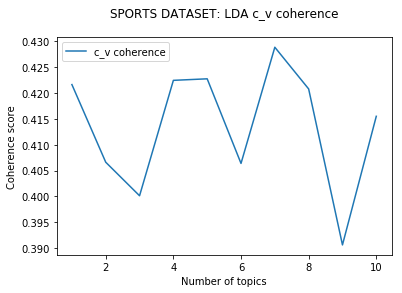

LDA Model Detected. Generating graph...



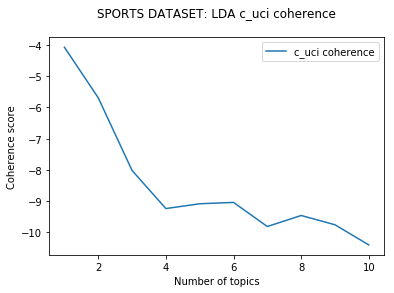

LDA Model Detected. Generating graph...



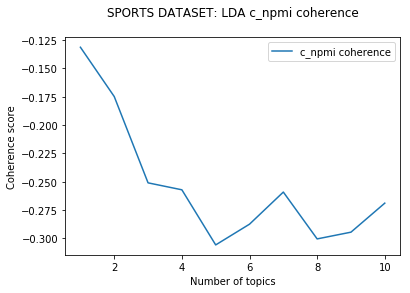

LDA Model Detected. Generating graph...



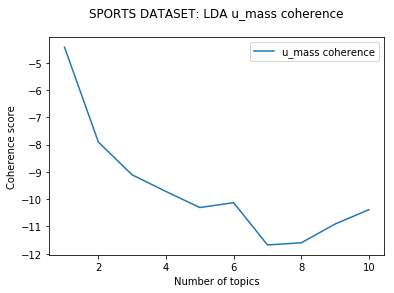

HDP Model Detected. Generating graph...



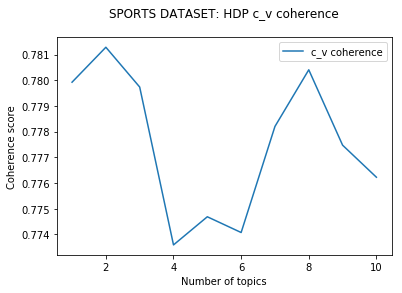

HDP Model Detected. Generating graph...



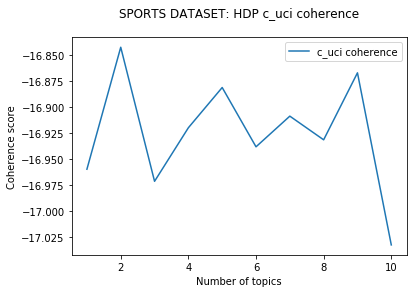

HDP Model Detected. Generating graph...



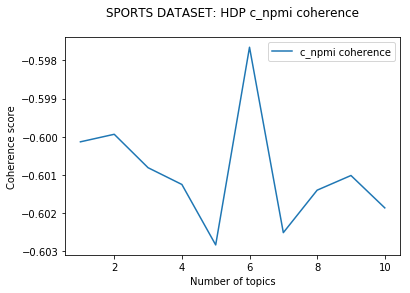

HDP Model Detected. Generating graph...



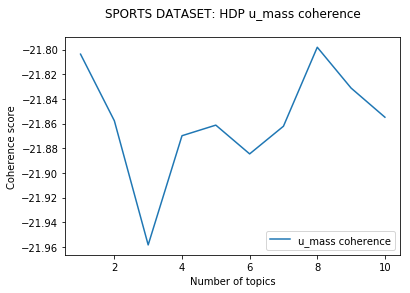

LSI Model Detected. Generating graph...



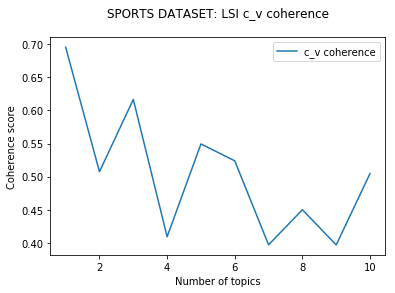

LSI Model Detected. Generating graph...



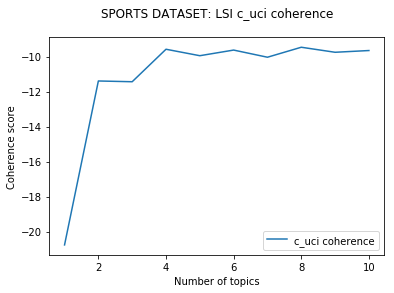

LSI Model Detected. Generating graph...



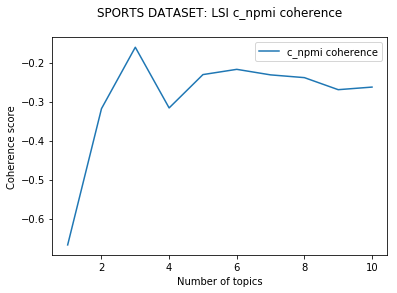

LSI Model Detected. Generating graph...



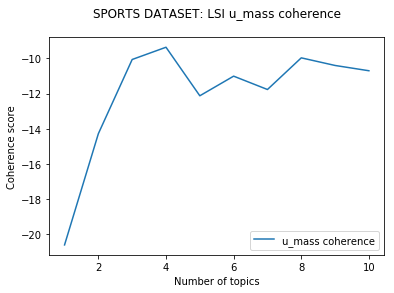

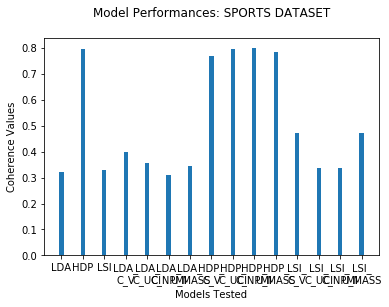

In [1]:
import os
import re
import operator
import matplotlib.pyplot as plt
import warnings
import gensim
import numpy as np
warnings.filterwarnings('ignore')

%matplotlib inline

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint

from gensim.utils import lemmatize
from nltk.corpus import stopwords

test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'sports.cor'

def build_texts(fname):
    with open(fname) as f:
        for line in f:
            yield gensim.utils.simple_preprocess(line, deacc=True, min_len=3)

train_texts = list(build_texts(lee_train_file))

bigram = gensim.models.Phrases(train_texts)

stops = set(stopwords.words('english'))

def process_texts(texts):
    texts = [[word for word in line if word not in stops] for line in texts]
    texts = [bigram[line] for line in texts]
    texts = [[word.split('/')[0] for word in lemmatize(' '.join(line), allowed_tags=re.compile('(NN)'), min_length=3)] for line in texts]
    return texts

train_texts = process_texts(train_texts)

dictionary = Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]

print '\nLSI Model Started'
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)
print lsimodel.show_topics(num_topics=5)
lsitopics = lsimodel.show_topics(formatted=False)

print 'LSI Model Ended\n\nHDP Model Started'
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
print hdpmodel.show_topics()
hdptopics = hdpmodel.show_topics(formatted=False)

print 'HDP Model Ended\n\nLDA Model Started'
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)
print ldamodel.show_topics()
ldatopics = ldamodel.show_topics(formatted=False)
print 'LDA Model Ended\n'

print 'Creating graphs...\n'

def evaluate_graph_general(dictionary, corpus, texts, limit, measure, model):
    coh_measure = []
    lm_list = []
    if model == 'LdaModel':
        print 'LDA Model Detected. Generating graph...\n'
    elif model == 'HdpModel':
        print 'HDP Model Detected. Generating graph...\n'
    elif model == 'LsiModel':
        print 'LSI Model Detected. Generating graph...\n'
    else:
        print 'Invalid Model!'
    
    for num_topics in range(1, limit):
        if model == 'LdaModel':
            lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        elif model == 'HdpModel':
            lm = HdpModel(corpus=corpus, id2word=dictionary)
        elif model == 'LsiModel':
            lm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        else:
            print 'Invalid Model!'
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence=measure)
        coh_measure.append(cm.get_coherence())

    # Show graph
    x = range(1, limit)
    
    if model == 'LdaModel':
        title = 'SPORTS DATASET: LDA'
    elif model == 'HdpModel':
        title = 'SPORTS DATASET: HDP'
    elif model == 'LsiModel':
        title = 'SPORTS DATASET: LSI'
    else:
        title = 'ERROR GRAPH'
    
    if measure == 'c_v':
        coh_label = 'c_v coherence'
    elif measure == 'c_uci':
        coh_label = 'c_uci coherence'
    elif measure == 'c_npmi':
        coh_label = 'c_npmi coherence'
    elif measure == 'u_mass':
        coh_label = 'u_mass coherence'
    else:
        coh_label = 'ERROR LABEL'
    
    plt.plot(x, coh_measure, label=coh_label)
    plt.title(title + ' ' + coh_label + '\n')
    plt.xlabel("Number of topics")
    plt.ylabel("Coherence score")
    plt.legend(loc='best')
    plt.show()

    return lm_list, coh_measure

# ----------------------------------LDA----------------------------------
# ----------------------------------c_v----------------------------------
ldalist_c_v, lda_c_v = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=11,
                                             measure='c_v',
                                             model='LdaModel')
ldatopics_c_v = ldalist_c_v[5].show_topics(formatted=False)
# ----------------------------------c_uci----------------------------------
ldalist_c_uci, lda_c_uci = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=11,
                                             measure='c_uci',
                                             model='LdaModel')
ldatopics_c_uci = ldalist_c_uci[5].show_topics(formatted=False)
# ----------------------------------c_npmi----------------------------------
ldalist_c_npmi, lda_c_npmi = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=11,
                                             measure='c_npmi',
                                             model='LdaModel')
ldatopics_c_npmi = ldalist_c_npmi[5].show_topics(formatted=False)
# ----------------------------------u_mass----------------------------------
ldalist_u_mass, lda_u_mass = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=11,
                                             measure='u_mass',
                                             model='LdaModel')
ldatopics_u_mass = ldalist_u_mass[5].show_topics(formatted=False)
# ----------------------------------LDA----------------------------------

# ----------------------------------HDP----------------------------------
# ----------------------------------c_v----------------------------------
hdplist_c_v, hdp_c_v = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=11,
                                             measure='c_v',
                                             model='HdpModel')
hdptopics_c_v = hdplist_c_v[5].show_topics(formatted=False)
# ----------------------------------c_uci----------------------------------
hdplist_c_uci, hdp_c_uci = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=11,
                                             measure='c_uci',
                                             model='HdpModel')
hdptopics_c_uci = hdplist_c_uci[5].show_topics(formatted=False)
# ----------------------------------c_npmi----------------------------------
hdplist_c_npmi, hdp_c_npmi = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=11,
                                             measure='c_npmi',
                                             model='HdpModel')
hdptopics_c_npmi = hdplist_c_npmi[5].show_topics(formatted=False)
# ----------------------------------u_mass----------------------------------
hdplist_u_mass, hdp_u_mass = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=11,
                                             measure='u_mass',
                                             model='HdpModel')
hdptopics_u_mass = hdplist_u_mass[5].show_topics(formatted=False)
# ----------------------------------HDP----------------------------------

# ----------------------------------LSI----------------------------------
# ----------------------------------c_v----------------------------------
lsilist_c_v, lsi_c_v = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=11,
                                             measure='c_v',
                                             model='LsiModel')
lsitopics_c_v = lsilist_c_v[5].show_topics(formatted=False)
# ----------------------------------c_uci----------------------------------
lsilist_c_uci, lsi_c_uci = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=11,
                                             measure='c_uci',
                                             model='LsiModel')
lsitopics_c_uci = lsilist_c_uci[5].show_topics(formatted=False)
# ----------------------------------c_npmi----------------------------------
lsilist_c_npmi, lsi_c_npmi = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=11,
                                             measure='c_npmi',
                                             model='LsiModel')
lsitopics_c_npmi = lsilist_c_npmi[5].show_topics(formatted=False)
# ----------------------------------u_mass----------------------------------
lsilist_u_mass, lsi_u_mass = evaluate_graph_general(dictionary=dictionary,
                                             corpus=corpus,
                                             texts=train_texts,
                                             limit=11,
                                             measure='u_mass',
                                             model='LsiModel')
lsitopics_u_mass = lsilist_u_mass[5].show_topics(formatted=False)
# ----------------------------------LSI----------------------------------

ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]

ldatopics_c_v = [[word for word, prob in topic] for topicid, topic in ldatopics_c_v]
ldatopics_c_uci = [[word for word, prob in topic] for topicid, topic in ldatopics_c_uci]
ldatopics_c_npmi = [[word for word, prob in topic] for topicid, topic in ldatopics_c_npmi]
ldatopics_u_mass = [[word for word, prob in topic] for topicid, topic in ldatopics_u_mass]

hdptopics_c_v = [[word for word, prob in topic] for topicid, topic in hdptopics_c_v]
hdptopics_c_uci = [[word for word, prob in topic] for topicid, topic in hdptopics_c_uci]
hdptopics_c_npmi = [[word for word, prob in topic] for topicid, topic in hdptopics_c_npmi]
hdptopics_u_mass = [[word for word, prob in topic] for topicid, topic in hdptopics_u_mass]

lsitopics_c_v = [[word for word, prob in topic] for topicid, topic in lsitopics_c_v]
lsitopics_c_uci = [[word for word, prob in topic] for topicid, topic in lsitopics_c_uci]
lsitopics_c_npmi = [[word for word, prob in topic] for topicid, topic in lsitopics_c_npmi]
lsitopics_u_mass = [[word for word, prob in topic] for topicid, topic in lsitopics_u_mass]

lda_coherence = CoherenceModel(topics=ldatopics, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics[:5], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
lsi_coherence = CoherenceModel(topics=lsitopics[:5], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_c_v_coherence = CoherenceModel(topics=ldatopics_c_v, texts=train_texts, dictionary=dictionary, window_size=110).get_coherence()
lda_c_uci_coherence = CoherenceModel(topics=ldatopics_c_uci, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
lda_c_npmi_coherence = CoherenceModel(topics=ldatopics_c_npmi, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
lda_u_mass_coherence = CoherenceModel(topics=ldatopics_u_mass, texts=train_texts, dictionary=dictionary, window_size=None).get_coherence()

hdp_c_v_coherence = CoherenceModel(topics=hdptopics_c_v, texts=train_texts, dictionary=dictionary, window_size=110).get_coherence()
hdp_c_uci_coherence = CoherenceModel(topics=hdptopics_c_uci, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
hdp_c_npmi_coherence = CoherenceModel(topics=hdptopics_c_npmi, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
hdp_u_mass_coherence = CoherenceModel(topics=hdptopics_u_mass, texts=train_texts, dictionary=dictionary, window_size=None).get_coherence()

lsi_c_v_coherence = CoherenceModel(topics=lsitopics_c_v, texts=train_texts, dictionary=dictionary, window_size=110).get_coherence()
lsi_c_uci_coherence = CoherenceModel(topics=lsitopics_c_uci, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
lsi_c_npmi_coherence = CoherenceModel(topics=lsitopics_c_npmi, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()
lsi_u_mass_coherence = CoherenceModel(topics=lsitopics_u_mass, texts=train_texts, dictionary=dictionary, window_size=None).get_coherence()

def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.title('Model Performances: SPORTS DATASET\n')
    plt.xlabel('Models Tested')
    plt.ylabel('Coherence Values')

evaluate_bar_graph([lda_coherence, hdp_coherence, lsi_coherence,
                    lda_c_v_coherence, lda_c_uci_coherence, lda_c_npmi_coherence, lda_u_mass_coherence,
                    hdp_c_v_coherence, hdp_c_uci_coherence, hdp_c_npmi_coherence, hdp_u_mass_coherence,
                    lsi_c_v_coherence, lsi_c_uci_coherence, lsi_c_npmi_coherence, lsi_u_mass_coherence],
                   ['LDA', 'HDP', 'LSI', 'LDA_\nC_V', 'LDA_\nC_UCI', 'LDA_\nC_NPMI', 'LDA_\nU_MASS', 'HDP_\nC_V', 'HDP_\nC_UCI', 'HDP_\nC_NPMI', 'HDP_\nU_MASS', 'LSI_\nC_V', 'LSI_\nC_UCI', 'LSI_\nC_NPMI', 'LSI_\nU_MASS'])

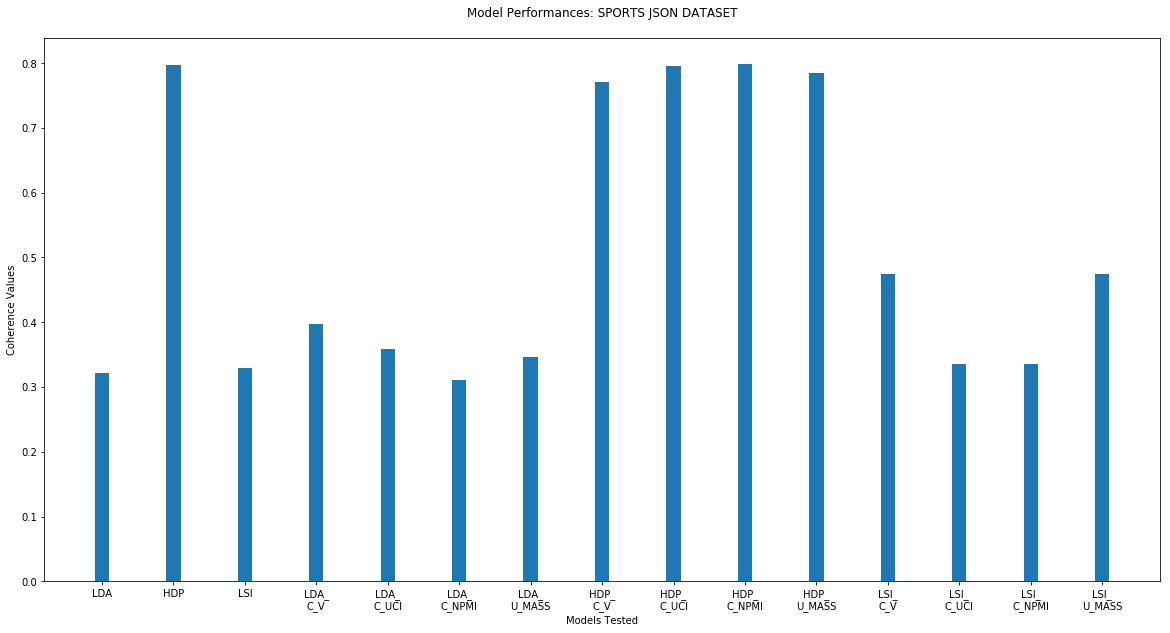

In [8]:
def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.title('Model Performances: SPORTS JSON DATASET\n')
    plt.xlabel('Models Tested')
    plt.ylabel('Coherence Values')
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] =2
    plt.rcParams["figure.figsize"] = fig_size

evaluate_bar_graph([lda_coherence, hdp_coherence, lsi_coherence,
                    lda_c_v_coherence, lda_c_uci_coherence, lda_c_npmi_coherence, lda_u_mass_coherence,
                    hdp_c_v_coherence, hdp_c_uci_coherence, hdp_c_npmi_coherence, hdp_u_mass_coherence,
                    lsi_c_v_coherence, lsi_c_uci_coherence, lsi_c_npmi_coherence, lsi_u_mass_coherence],
                   ['LDA', 'HDP', 'LSI', 'LDA_\nC_V', 'LDA_\nC_UCI', 'LDA_\nC_NPMI', 'LDA_\nU_MASS', 'HDP_\nC_V', 'HDP_\nC_UCI', 'HDP_\nC_NPMI', 'HDP_\nU_MASS', 'LSI_\nC_V', 'LSI_\nC_UCI', 'LSI_\nC_NPMI', 'LSI_\nU_MASS'])